# Tesla Stock Price Prediction
## Author: Eren ERİŞ

Tesla ya ait Hise senetlerin LSTM Model ile tahmin edilmesine dayanır

In [6]:
#Veriyi okuma ve işleme adımında kullanılacak kütüphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

#Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Model için kullanılacak kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping

#Warningleri Kapatmak İçin
import warnings
warnings.filterwarnings('ignore')

#TensorFlow Warningleri Engelleme
import os
os.environ['TF_CPP_LOG_LEVEL']='3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 088F-1ED4

 Directory of C:\Users\EREN\Documents\YapayZeka\GitHub\21Project\Tesla Stock Price Prediction

01/04/2024  08:30 PM    <DIR>          .
01/04/2024  08:30 PM    <DIR>          ..
01/04/2024  08:30 PM    <DIR>          .ipynb_checkpoints
12/25/2023  10:54 PM            19,015 TSLA.csv
01/04/2024  08:30 PM                72 Untitled.ipynb
               2 File(s)         19,087 bytes
               3 Dir(s)  61,026,074,624 bytes free


In [4]:
df = pd.read_csv("TSLA.csv")

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400
1,2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500
2,2022-12-29,120.389999,123.570000,117.500000,121.820000,121.820000,221923300
3,2022-12-30,119.949997,124.480003,119.750000,123.180000,123.180000,157777300
4,2023-01-03,118.470001,118.800003,104.639999,108.099998,108.099998,231402800


In [7]:
def check_df(dataframe,head=5):
    print("################ Shape ###################")
    print(dataframe.shape)
    print("################ Types ###################")
    print(dataframe.dtypes)
    print("################ Head ###################")
    print(dataframe.head(head))
    print("################ Tail ###################")
    print(dataframe.tail(head))
    print("################ Na ###################")
    print(dataframe.isnull().sum())
    print("################ Quantiles ###################")
    print(dataframe.quantile([0,0.05,0.50,0.95,0.99,1]).T)

In [8]:
check_df(df)

################ Shape ###################
(250, 7)
################ Types ###################
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
################ Head ###################
         Date        Open        High         Low       Close   Adj Close  \
0  2022-12-27  117.500000  119.669998  108.760002  109.099998  109.099998   
1  2022-12-28  110.349998  116.269997  108.239998  112.709999  112.709999   
2  2022-12-29  120.389999  123.570000  117.500000  121.820000  121.820000   
3  2022-12-30  119.949997  124.480003  119.750000  123.180000  123.180000   
4  2023-01-03  118.470001  118.800003  104.639999  108.099998  108.099998   

      Volume  
0  208643400  
1  221070500  
2  221923300  
3  157777300  
4  231402800  
################ Tail ###################
           Date        Open        High         Low       Close   Adj Close  \
245  2023-12-18  253.779999 

In [9]:
df["Date"]=pd.to_datetime(df["Date"])

In [10]:
tesla_df = df[["Date","Close"]]

In [11]:
tesla_df.index = tesla_df["Date"]

In [12]:
tesla_df.drop("Date",axis=1,inplace=True)

In [13]:
result_df = tesla_df.copy()

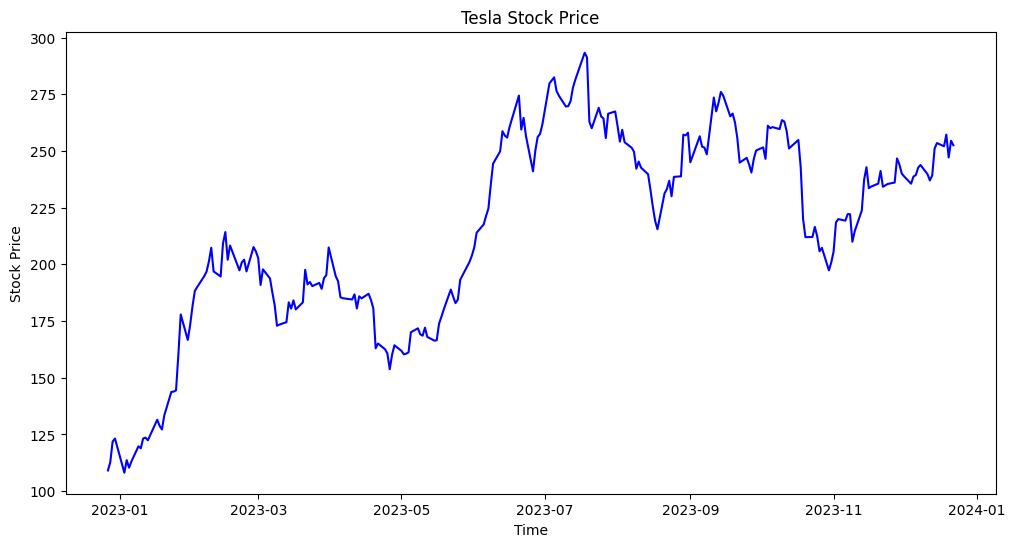

In [14]:
plt.figure(figsize=(12,6))
plt.plot(tesla_df['Close'],color='blue');
plt.ylabel('Stock Price')
plt.title('Tesla Stock Price')
plt.xlabel('Time')
plt.show()


In [15]:
tesla_df = tesla_df.values

In [16]:
tesla_df = tesla_df.astype('float32')

In [18]:
def split_data(dataframe,test_size):
    position = int(round(len(dataframe)*(1-test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train , test , position

In [19]:
train , test , position = split_data(tesla_df , 0.2)

In [20]:
print(train.shape,test.shape)

(200, 1) (50, 1)


In [21]:
scaler_train = MinMaxScaler(feature_range=(0,1))
train = scaler_train.fit_transform(train)

In [22]:
scaler_test = MinMaxScaler(feature_range=(0,1))
test = scaler_test.fit_transform(test)

In [23]:
def create_features(data,lookback):
    X,Y =[] ,[]
    for i in range(lookback,len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X),np.array(Y)

In [24]:
lookback = 10
#Train Veri Seti
X_train , y_train = create_features(train , lookback)
print(X_train.shape,y_train.shape)

(190, 10) (190,)


In [25]:
#Test Veri Seti
X_test , y_test = create_features(test , lookback)
print(X_test.shape,y_test.shape)

(40, 10) (40,)


In [26]:
X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [27]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(190, 1, 10) (190, 1) (40, 1, 10) (40, 1)


In [28]:
model = Sequential()

model.add(LSTM(units=50,
                   activation='relu',
                   input_shape=(X_train.shape[1],lookback)))

model.add(Dropout(0.05))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                12200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [30]:
callbacks = [EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode='min'),
             ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',
                             save_best_only=True,save_weights_only=False,verbose=1)]

In [31]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=50,
                    batch_size=1,
                    validation_data=(X_test,y_test),
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/50
177/190 [==========================>...] - ETA: 0s - loss: 0.0183
Epoch 1: val_loss improved from inf to 0.03470, saving model to mymodel.h5
190/190 [==============================] - 3s 5ms/step - loss: 0.0179 - val_loss: 0.0347
Epoch 2/50
179/190 [===========================>..] - ETA: 0s - loss: 0.0080
Epoch 2: val_loss improved from 0.03470 to 0.02996, saving model to mymodel.h5
190/190 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0300
Epoch 3/50
166/190 [=========================>....] - ETA: 0s - loss: 0.0062
Epoch 3: val_loss improved from 0.02996 to 0.02493, saving model to mymodel.h5
190/190 [==============================] - 1s 3ms/step - loss: 0.0068 - val_loss: 0.0249
Epoch 4/50
189/190 [============================>.] - ETA: 0s - loss: 0.0072
Epoch 4: val_loss improved from 0.02493 to 0.02208, saving model to mymodel.h5
190/190 [==============================] - 1s 3ms/step - loss: 0.0074 - val_loss: 0.0221
Epoch 5/50
188/190 [====

Text(0.5, 1.0, 'Training and Validation Loss')

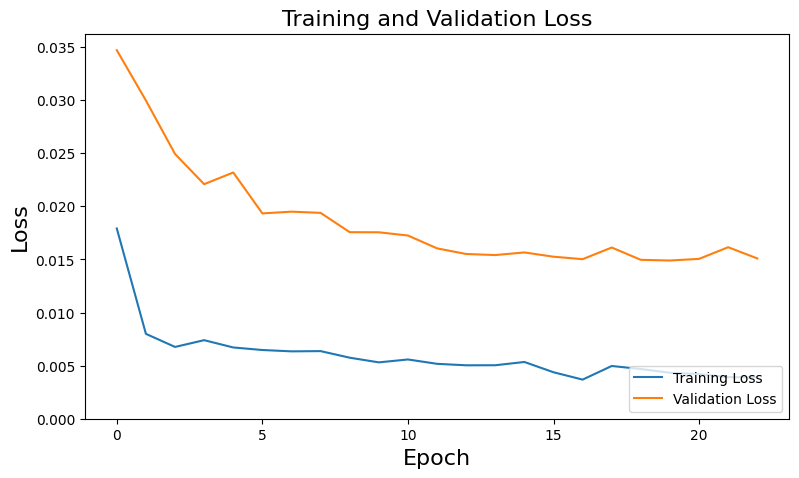

In [32]:
#------------------------
#Loss Grafik
#------------------------
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='lower right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss',fontsize=16)

In [33]:
loss = model.evaluate(X_test,y_test,batch_size=1)
print("\nTest loss: %.1f%%"%(100.0*loss))

40/40 [==============================] - 0s 1ms/step - loss: 0.0151

Test loss: 1.5%


In [34]:
train_predict = model.predict(X_train)

6/6 [==============================] - 0s 3ms/step


In [35]:
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [36]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [37]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [38]:
#Train Veri Seti ait RMSE Değeri
train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))
#Test Veri Seti ait RMSE Değeri
test_rmse = np.sqrt(mean_squared_error(y_test,test_predict))

In [39]:
print(f"Train RMSE:{train_rmse}")
print(f"Test RMSE:{test_rmse}")

Train RMSE:15.353507041931152
Test RMSE:7.353031635284424


In [40]:
train_prediction_df=result_df[lookback:position]
train_prediction_df["Predicted"] = train_predict
train_prediction_df.head()

,Close,Predicted
Date,,
2023-01-11,123.220001,133.372314
2023-01-12,123.559998,135.636078
2023-01-13,122.400002,137.985550
2023-01-17,131.490005,137.479507
2023-01-18,128.779999,142.165558


In [43]:
test_prediction_df=result_df[lookback+position:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Close,Predicted
Date,,
2023-10-27,207.300003,219.685486
2023-10-30,197.360001,218.126465
2023-10-31,200.839996,214.476013
2023-11-01,205.660004,211.982086
2023-11-02,218.509995,211.854248


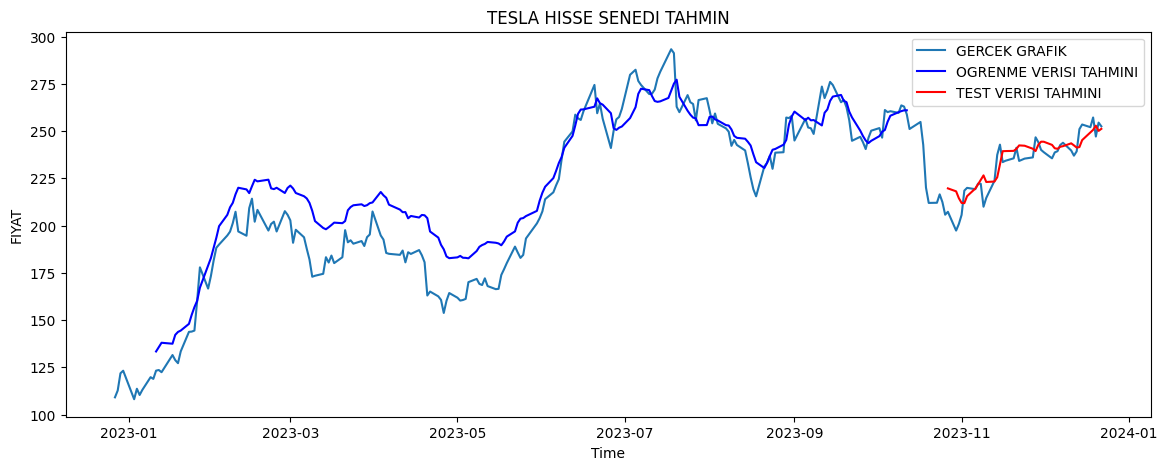

In [45]:
plt.figure(figsize=(14,5))
plt.plot(result_df,label="GERCEK GRAFIK")
plt.plot(train_prediction_df["Predicted"],color='blue',label='OGRENME VERISI TAHMINI')
plt.plot(test_prediction_df["Predicted"],color='red',label='TEST VERISI TAHMINI')
plt.title('TESLA HISSE SENEDI TAHMIN')
plt.xlabel('Time')
plt.ylabel('FIYAT')
plt.legend()
plt.show()